In [ ]:
import pandas as pd
import numpy as np
import os
import string as str
import nltk
import re
import spacy

from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Lấy dữ liệu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def get_data(file_path : str):
  if os.path.exists(file_path):
    try:
      data = pd.read_csv(file_path)
      return data
    except Exception as e:
      print(f"Error reading CSV file: {e}")
      return None
  else:
    print(f"File not found at: {file_path}")
    return None

In [ ]:
df = get_data('/content/drive/MyDrive/Dữ liệu/data_last.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67043 entries, 0 to 67042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  66681 non-null  object
 1   status     67043 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


# Tiền xử lý dữ liệu

Loại bỏ cột id (Unnamed: 0)

Fill các giá trị rỗng thành ''

In [ ]:
df['statement'].fillna('', inplace=True)

## a) Xử lý nhiễu

In [ ]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

Làm sạch text bằng cách:


1.   Chuyển về dạng chữ thường
2.   Xóa các đường dẫn, HTML tags
3.   Xóa các dấu chấm câu, dấu xuống dòng
4.   Xóa các chữ chứa số (VD: 1dea, ..)



In [ ]:
def clean_text(text):
  text = text.lower()
  text = re.sub(r'\[.*?\]', '', text)
  text = re.sub(r'[%s]' % re.escape(str.punctuation), '', text)
  text = re.sub(r'\w*\d\w*', '', text)
  text = re.sub(r'https?://\S+|www\.\S+', '', text)
  text = re.sub(r'\n', '', text)
  return text

Loại bỏ các từ dừng (stopwords) (VD: is, the, a, an, ...) không đóng góp nhiều giá trị vào phần nội dung

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
def remove_stopwords(text):
  words = word_tokenize(text)
  tokens = [word for word in words if word.casefold() not in stop_words]
  return ' '.join(tokens)

Loại bỏ các từ không phải là tiếng Anh

In [ ]:
english_words = set(words.words())

In [ ]:
def remove_non_english_words(text):
  words = word_tokenize(text)
  tokens = [word for word in words if word.casefold() in english_words]
  return ' '.join(tokens)

Gộp các từ về dạng gốc (VD: happy, happier, happiness -> happy)

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
def lemmatize(text):
  doc = nlp(text)
  tokens = [token.lemma_ for token in doc if token.is_alpha]
  return ' '.join(tokens)

In [ ]:
special_words = set(['feel', 'know', 'go', 'think', 'even', 'really','want', 'time', 'one', 'make', 'people', 'go'])

In [ ]:
def remove_sw(text):
  words = word_tokenize(text)
  tokens = [word for word in words if word.casefold() not in special_words]
  return ' '.join(tokens)

In [ ]:
df['statement'] = df['statement'].apply(lambda x: clean_text(x))
df['statement'] = df['statement'].apply(lambda x: remove_stopwords(x))
df['statement'] = df['statement'].apply(lambda x: remove_sw(x))
df['statement'] = df['statement'].apply(lambda x: lemmatize(x))

## b) Xử lý giá trị null

In [ ]:
df.isnull().sum()

,0
statement,0
status,0


In [ ]:
df.drop(df[df['statement'] == ''].index, inplace=True)

# Tạo đặc trưng

Tạo đặc trưng length_of_statement

In [ ]:
df['length_of_statement'] = df.apply(lambda x: len(x['statement']), axis=1)

Kiểm tra độ dài trung bình với mỗi status

In [ ]:
df.groupby('status')['length_of_statement'].count()

,length_of_statement
status,
Anxiety,3841
Bipolar,2777
Depression,22401
Normal,16132
Personality disorder,1077
Stress,2587
Suicidal,17643


In [ ]:

df['tokens'] = df['statement'].apply(word_tokenize).apply(lambda tokens: [token for token in tokens if len(token) > 1])
df.head()

,statement,status,length_of_statement,tokens
0,oh gosh,Anxiety,7,"[oh, gosh]"
1,trouble sleep confused mind restless heart tune,Anxiety,47,"[trouble, sleep, confused, mind, restless, hea..."
2,wrong back dear forward doubt stay restless re...,Anxiety,58,"[wrong, back, dear, forward, doubt, stay, rest..."
3,I ve shift focus something else I m still worried,Anxiety,49,"[ve, shift, focus, something, else, still, wor..."
4,I m restless restless month boy mean,Anxiety,36,"[restless, restless, month, boy, mean]"


## Trực quan hóa

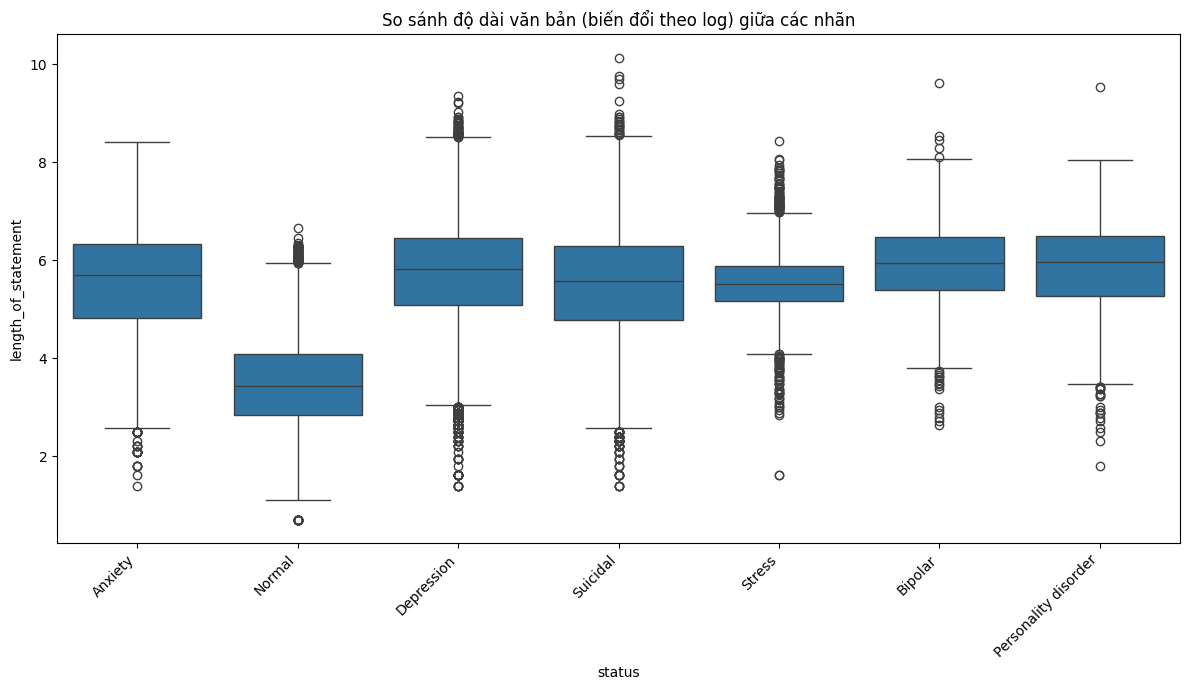

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 7)) # Increased figure size
sns.boxplot(x='status', y=np.log1p(df['length_of_statement']), data=df) # Apply log1p transformation
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels
plt.title('So sánh độ dài văn bản (biến đổi theo log) giữa các nhãn') # Update title
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()

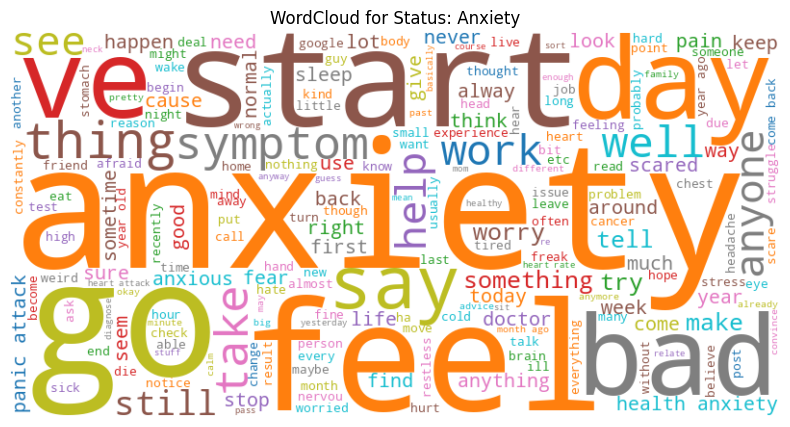

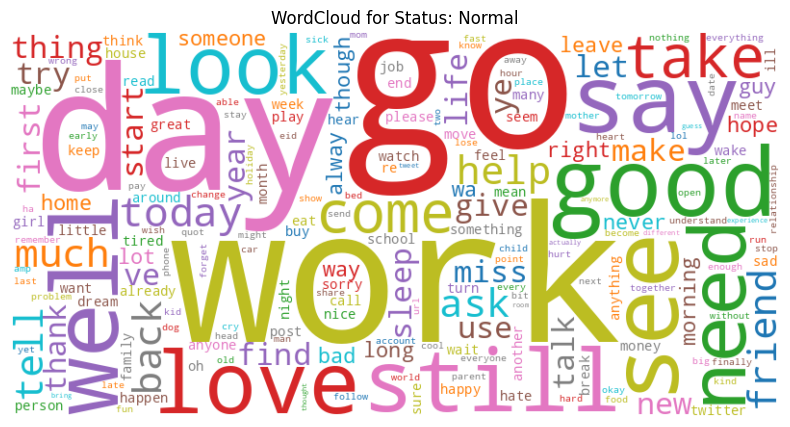

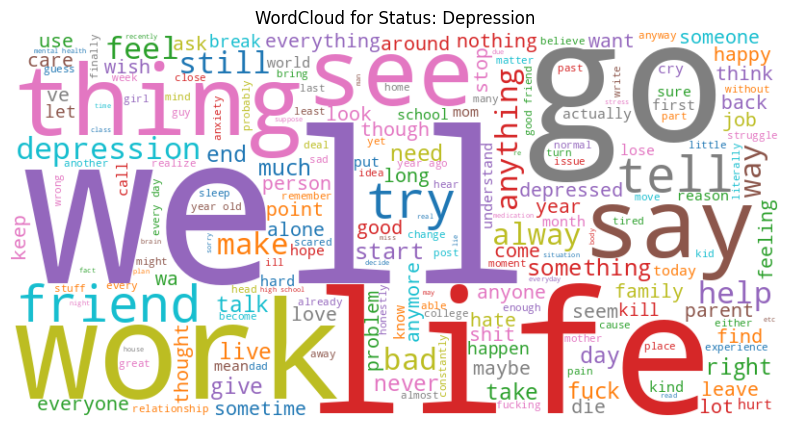

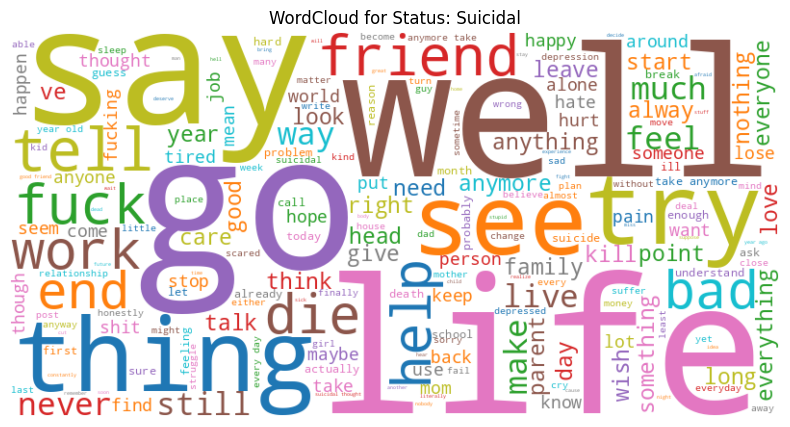

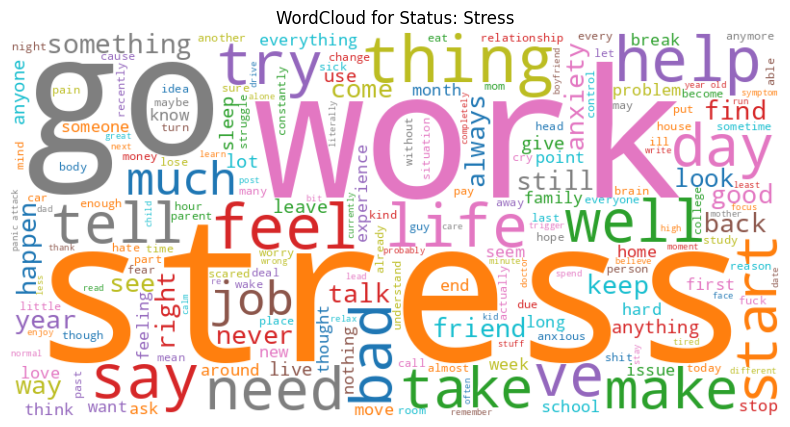

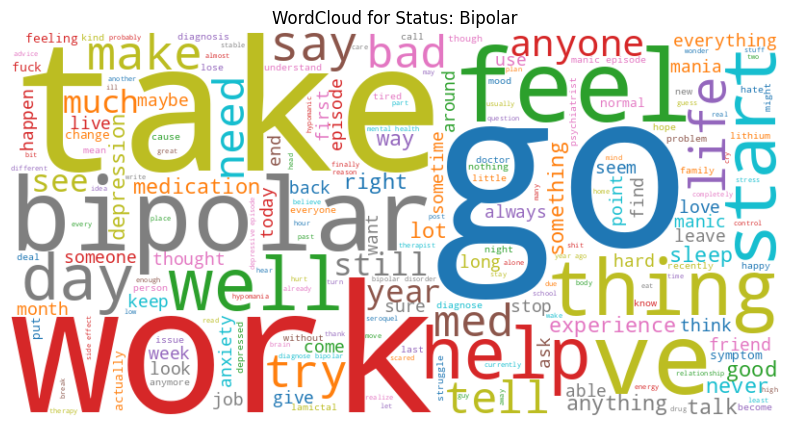

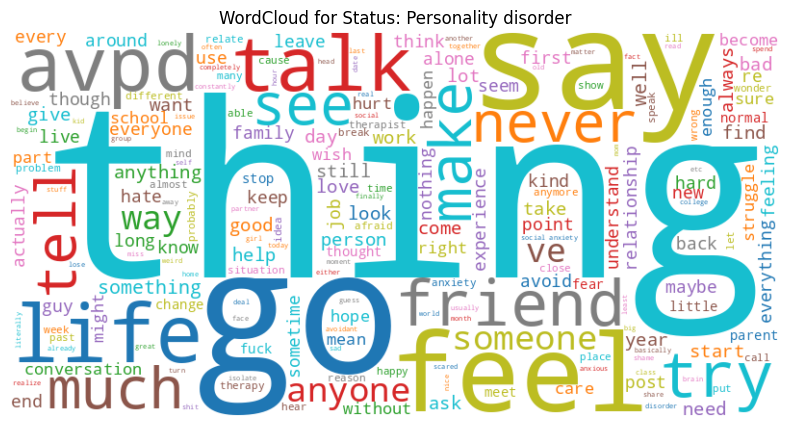

In [ ]:
from wordcloud import WordCloud
import random
import matplotlib.pyplot as plt

# Get unique categories in 'status'
statuses = df['status'].unique()

# Define a list of colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

# Generate and plot the WordCloud for each category
for status in statuses:
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)

    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}')
    plt.show()

In [ ]:
color_map = {
    'Normal': '#1f77b4',
    'Depression': '#ff7f0e',
    'Suicidal': '#2ca02c',
    'Anxiety': '#d62728',
    'Bipolar': '#9467bd',
    'Stress': '#8c564b',
    'Personality disorder': '#e377c2'
}

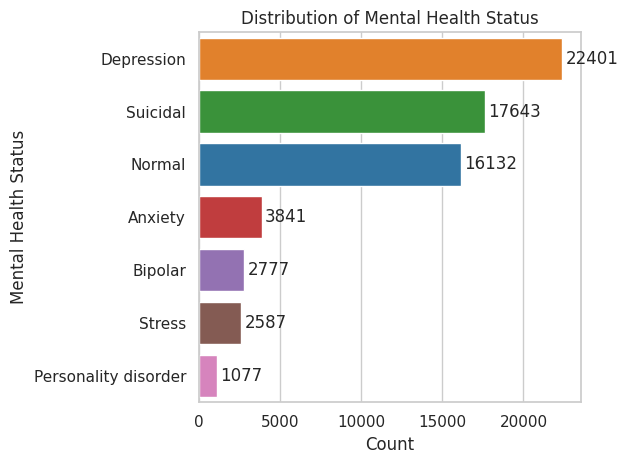

In [ ]:
sns.set(style="whitegrid")
order = df['status'].value_counts().index
palette = {k: color_map[k] for k in order}

ax = sns.countplot(data=df, y='status', order=order, palette=palette)
for p in ax.patches:
    count = int(p.get_width())
    ax.text(p.get_width() + 200,
            p.get_y() + p.get_height() / 2,
            count, va='center')
plt.title("Distribution of Mental Health Status")
plt.xlabel("Count")
plt.ylabel("Mental Health Status")

plt.tight_layout()
plt.show()

<Axes: ylabel='count'>

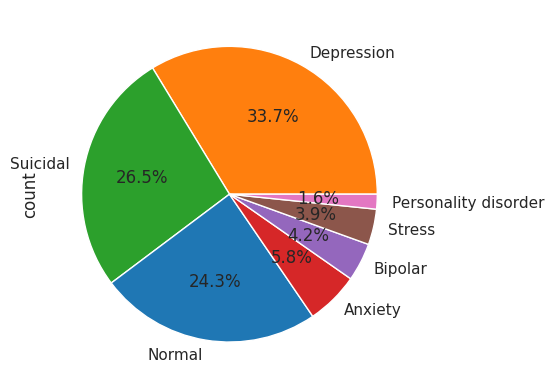

In [ ]:
labels = df['status'].value_counts().head(10).index
colors = [color_map[label] for label in labels]

df['status'].value_counts().head(10).plot.pie(
    autopct='%1.1f%%',
    colors=colors
)

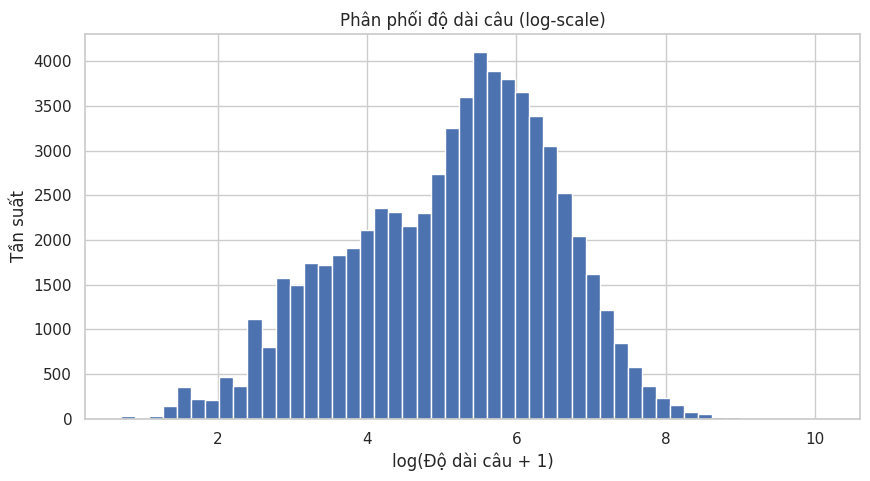

In [ ]:
df['length_of_statement'].apply(np.log1p).hist(figsize=(10, 5), bins=50)
plt.xlabel("log(Độ dài câu + 1)")
plt.ylabel("Tần suất")
plt.title("Phân phối độ dài câu (log-scale)")
plt.show()